# Drought Network Graph Manipulation
8.29.2022, a. stein

Upon wanting to improve filtering and other graph manipulation operations, I'm seeing the adjacency matrix as perhaps not the best method to do this. Here I will explore with adjacency lists instead and being able to include/exclude nodes with (hopefully) greater easy and coding simplicity.

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

from tqdm.autonotebook import tqdm

import sys
sys.path.append('../../')
import ndrought.wrangle as wrangle
import ndrought.compare as compare
import ndrought.plotting as ndplot
import ndrought.drought_network as dnet

import networkx as nx

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/tmp/ipykernel_2638124/2503306668.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Setup test cases

In [2]:
def tick(matrix):
    new_state = np.copy(matrix)

    i_dim, j_dim = matrix.shape

    for i in range(i_dim):
        for j in range(j_dim):
            north = matrix[i][j-1] if j>0 else 0
            south = matrix[i][j+1] if j<(j_dim-1) else 0
            west = matrix[i+1][j] if i<(i_dim-1) else 0
            east = matrix[i-1][j] if i>0 else 0
            se = matrix[i+1][j+1] if i<(i_dim-1) and j<(j_dim-1) else 0
            sw = matrix[i+1][j-1] if i<(i_dim-1) and j>0 else 0
            ne = matrix[i-1][j+1] if i>0 and j<(j_dim-1) else 0
            nw = matrix[i-1][j-1] if i>0 and j>0 else 0
            neighbors = np.sum([north, south, west, east, se, sw, ne, nw])

            # rules
            if matrix[i][j] == 0 and neighbors == 3: # reproduction
                new_state[i][j] = 1
            elif matrix[i][j] == 1 and neighbors < 2: # underpopulation
                new_state[i][j] = 0
            elif matrix[i][j] == 1 and neighbors > 3: # overpopulation
                new_state[i][j] = 0
            elif matrix[i][j] == 1 and neighbors == 2: # survives
                new_state[i][j] = 1
            elif matrix[i][j] == 1 and neighbors == 3: # also survives
                new_state[i][j] = 1

    return new_state

### 5x5 bounded grid (hard-coded)

In [3]:
# this was originally generated randomly using the same method method as
# before, but I have now hard coded it to have a consistent test example
ca_matrix_5x5 = np.array([
    [0, 0, 0, 0, 0],
    [0, 1, 1, 0, 1],
    [1, 1, 0, 0, 1],
    [1, 1, 1, 0, 1],
    [0, 0, 1, 0, 1]
])

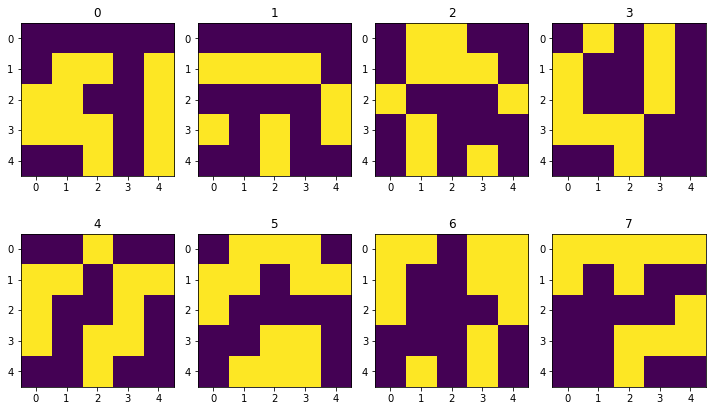

In [4]:
fig, axs = plt.subplots(2, 4, figsize=(10,6))

ca_series_5x5 = []
plot_matrix = ca_matrix_5x5

for i, ax in enumerate(axs.ravel()):
    ca_series_5x5.append(plot_matrix)
    ax.imshow(plot_matrix)
    plot_matrix = tick(plot_matrix)

    ax.set_title(i)

ca_series_5x5 = np.array(ca_series_5x5)

plt.tight_layout()

In [5]:
ca_net_5x5 = dnet.DroughtNetwork(ca_series_5x5, name="5x5 Cellular Automata")

  0%|          | 0/8 [00:00<?, ?it/s]

In [6]:
adjacency_dict = dict()

for node in ca_net_5x5:
    id = node.id
    if id not in adjacency_dict.keys():
        adjacency_dict[id] = []
    for future in node.future:
        adjacency_dict[id].append(future.id)

In [7]:
adjacency_dict

{0: [2, 3, 4],
 1: [2],
 2: [5],
 3: [],
 4: [],
 5: [7],
 6: [],
 7: [8],
 8: [9, 10],
 9: [11, 12],
 10: [12, 13],
 11: [14],
 12: [14, 15],
 13: [],
 14: [],
 15: []}

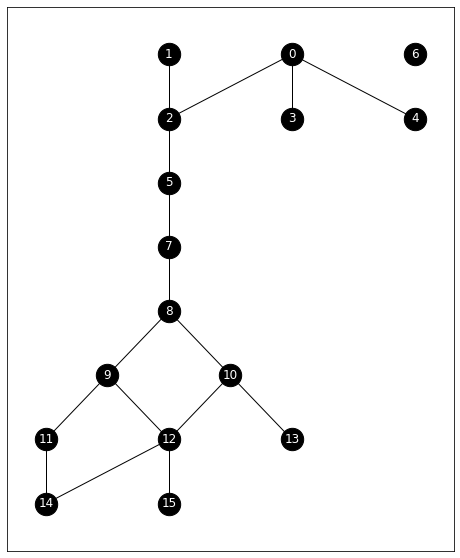

In [8]:
fig, ax = plt.subplots(figsize=(8,10))
G = nx.Graph(adjacency_dict)
nx.draw_networkx(G, nx.drawing.nx_agraph.graphviz_layout(G, prog= 'dot'), with_labels=True, font_color='white', node_color='k', ax=ax, node_size=500, font_size=12)

Awesome. We get the correct graph out. Let's try some operations

What if I want to follow a thread?

In [9]:
thread_5 = ca_net_5x5.get_chronological_future_thread(5)
thread_5_id = [node.id for node in thread_5]

adjacency_dict = dict()

for node in ca_net_5x5:
    id = node.id
    if id in thread_5_id:
        if id not in adjacency_dict.keys():
            adjacency_dict[id] = []
        for future in node.future:
            f_id = future.id
            if f_id in thread_5_id:
                adjacency_dict[id].append(future.id)

In [10]:
adjacency_dict

{5: [7],
 7: [8],
 8: [9, 10],
 9: [11, 12],
 10: [12, 13],
 11: [14],
 12: [14, 15],
 13: [],
 14: [],
 15: []}

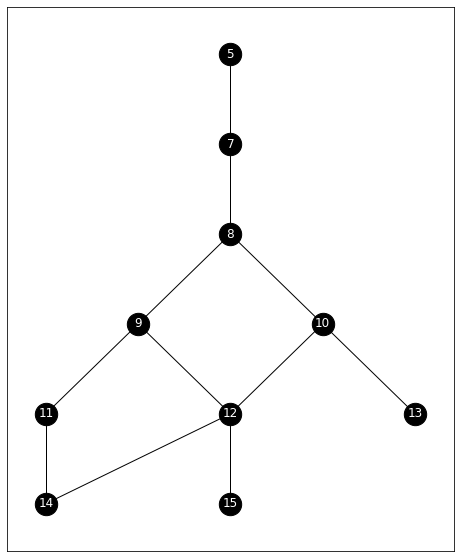

In [11]:
fig, ax = plt.subplots(figsize=(8,10))

G = nx.Graph(adjacency_dict)
nx.draw_networkx(G, nx.drawing.nx_agraph.graphviz_layout(G, prog= 'dot'), with_labels=True, font_color='white', node_color='k', ax=ax, node_size=500, font_size=12)

Good. Good. What if I want to do something like not use a pre-defined filter but just give it the nodes I want to include?

In [12]:
plot_ids = [0, 2, 3, 4, 9, 11, 14, 10, 13]

adjacency_dict = dict()

for node in ca_net_5x5:
    id = node.id
    if id in plot_ids:
        if id not in adjacency_dict.keys():
            adjacency_dict[id] = []
        for future in node.future:
            f_id = future.id
            if f_id in plot_ids:
                adjacency_dict[id].append(future.id)

In [13]:
adjacency_dict

{0: [2, 3, 4],
 2: [],
 3: [],
 4: [],
 9: [11],
 10: [13],
 11: [14],
 13: [],
 14: []}

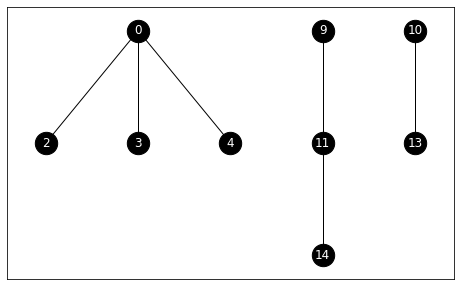

In [14]:
fig, ax = plt.subplots(figsize=(8,5))

G = nx.Graph(adjacency_dict)
nx.draw_networkx(G, nx.drawing.nx_agraph.graphviz_layout(G, prog= 'dot'), with_labels=True, font_color='white', node_color='k', ax=ax, node_size=500, font_size=12)

Perfect.

Can this be colored?

In [15]:
cmap = plt.cm.get_cmap('viridis')
color_map = []
color_vals = np.zeros(len(adjacency_dict))

for i, id in enumerate(adjacency_dict.keys()):
    color_vals[i] = ca_net_5x5.find_node_by_id(id).time

max_val = color_vals.max()
color_vals = color_vals/max_val

for val in color_vals:
    color_map.append(cmap(val)[:-1])

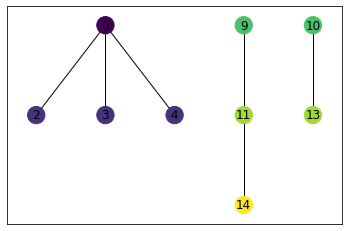

In [16]:
G = nx.Graph(adjacency_dict)
nx.draw_networkx(G, nx.drawing.nx_agraph.graphviz_layout(G, prog= 'dot'), with_labels=True, node_color=color_map)

Woot

One more speed-up idea: let's say we save the adjacency dictionary as part of the class, and then we don't want to remake it every single time. Can I spawn a dictionary from an existing dictionary given selection criteria?

In [17]:
# going to return to the overarching one
adjacency_dict = dict()

for node in ca_net_5x5:
    id = node.id
    if id not in adjacency_dict.keys():
        adjacency_dict[id] = []
    for future in node.future:
        adjacency_dict[id].append(future.id)

In [18]:
plot_ids = [0, 2, 3, 4, 9, 11, 14, 10, 13]

adjacency_dict_filtered = dict()

for id in plot_ids:
    adj_dict_vals = adjacency_dict[id]
    adj_dict_vals_filtered = []
    for val in adj_dict_vals:
        if val in plot_ids:
            adj_dict_vals_filtered.append(val)
    adjacency_dict_filtered[id] = adj_dict_vals_filtered

In [19]:
adjacency_dict_filtered

{0: [2, 3, 4],
 2: [],
 3: [],
 4: [],
 9: [11],
 11: [14],
 14: [],
 10: [13],
 13: []}

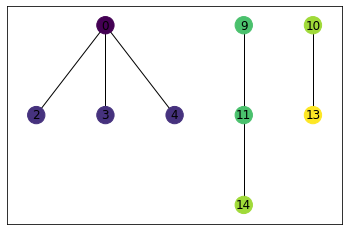

In [20]:
G = nx.Graph(adjacency_dict_filtered)
nx.draw_networkx(G, nx.drawing.nx_agraph.graphviz_layout(G, prog= 'dot'), with_labels=True, node_color=color_map)

Beautiful.

Now to do an overhaul of the `DroughtNetwork` class with this

Also need to double check the `to_array` with this update

In [21]:
filtered_array = ca_net_5x5.to_array(adj_dict=adjacency_dict_filtered)
filtered_array.shape

(8, 5, 5)

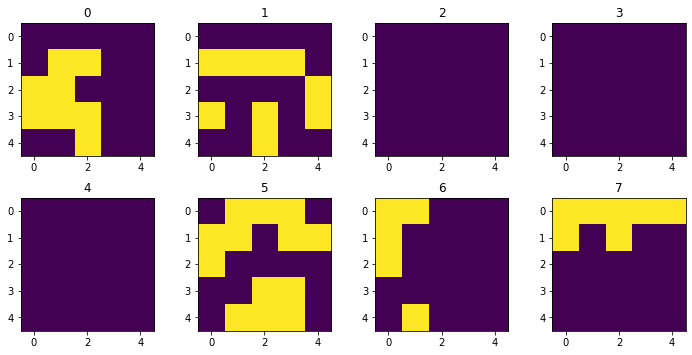

In [22]:
fig, axs = plt.subplots(2,4, figsize=(10,5))

for i, ax in enumerate(axs.ravel()):
    ax.imshow(filtered_array[i,:,:])
    ax.set_title(i)

plt.tight_layout()

Delightful.

## Converting back into original non-binary values

In [23]:
import xarray as xr

In [24]:
dm_path = '/pool0/home/steinadi/data/drought/drought_impact/data/drought_measures'

In [25]:
usdm = xr.open_dataset(f'{dm_path}/usdm/USDM_WA_20000104_20220412.nc')

(array([22312520.,        0.,  8446756.,        0.,  4628104.,        0.,
         2918844.,        0.,   676092.,   177057.]),
 array([-1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ]),
 <BarContainer object of 10 artists>)

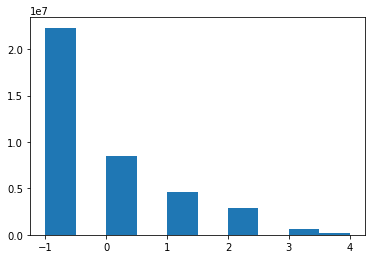

In [26]:
plt.hist(usdm['USDM'].values.ravel())

In [27]:
usdm_net = dnet.DroughtNetwork(usdm['USDM'].values, name='USDM EPSG:4326')

  0%|          | 0/1163 [00:00<?, ?it/s]

(array([22312520.,        0.,  8446756.,        0.,  4628104.,        0.,
         2918844.,        0.,   676092.,   177057.]),
 array([-1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ]),
 <BarContainer object of 10 artists>)

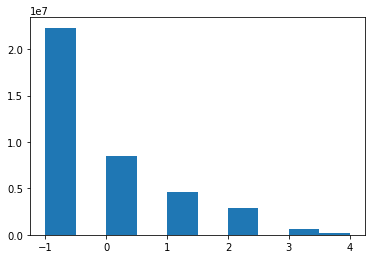

In [28]:
plt.hist(usdm['USDM'].values.ravel())

In [29]:
usdm_thread_893 = usdm_net.to_array(id=893)

In [30]:
usdm['date'].values[731]

numpy.datetime64('2014-01-07T00:00:00.000000000')

In [31]:
usdm['date'].values[846]

numpy.datetime64('2016-03-22T00:00:00.000000000')

In [32]:
usdm_original_period = usdm['USDM'].isel(date=np.arange(731, 846+1, 1))

In [33]:
cmap = ndplot.usdm_cmap()

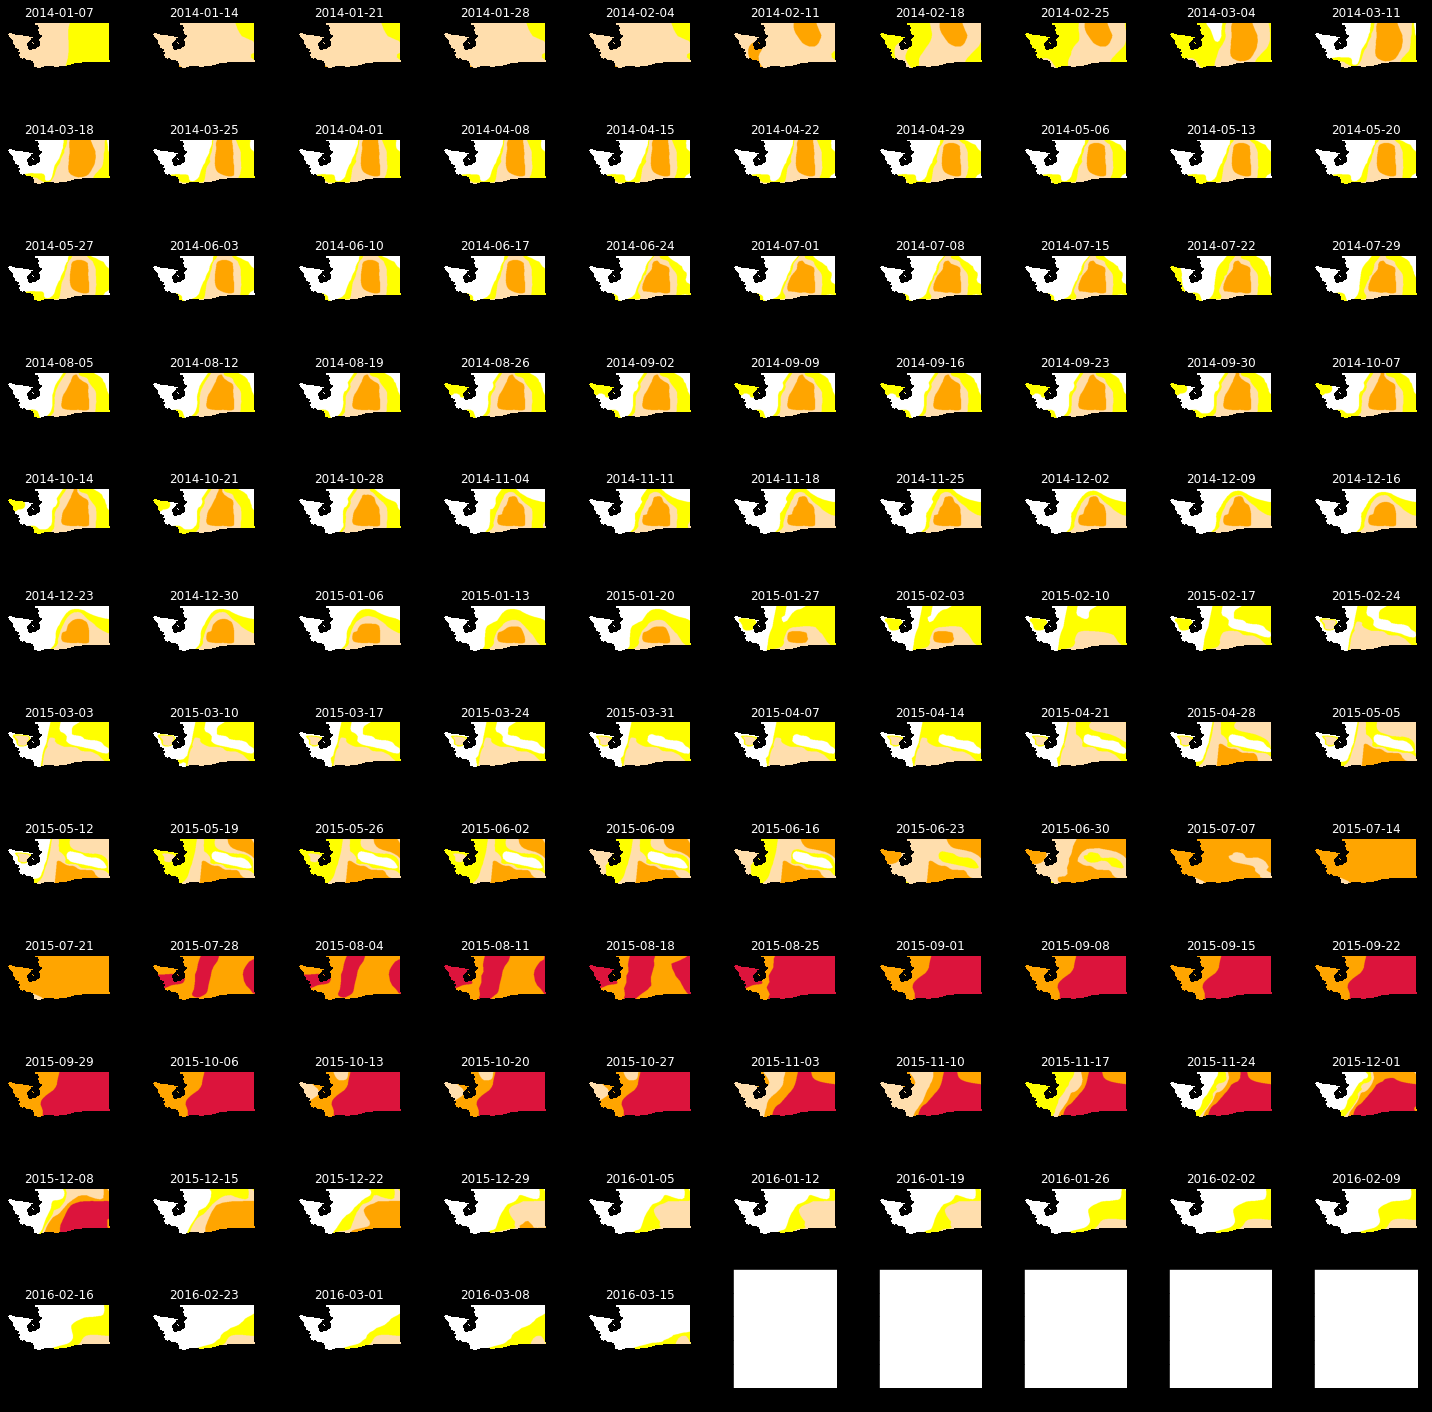

In [34]:
fig, axs = plt.subplots(12,10, figsize=(20,20))
axs_list = axs.ravel()

for i in np.arange(115):
    ax = axs_list[i]
    ax.imshow(usdm_original_period.values[i,:,:], vmin=-1, vmax=4, cmap=cmap)
    ax.axis('off')
    ax.set_aspect('equal')
    ax.set_title(np.datetime_as_string(usdm_original_period['date'].values[i])[:10], color='w')
fig.set_facecolor('k')
plt.tight_layout()

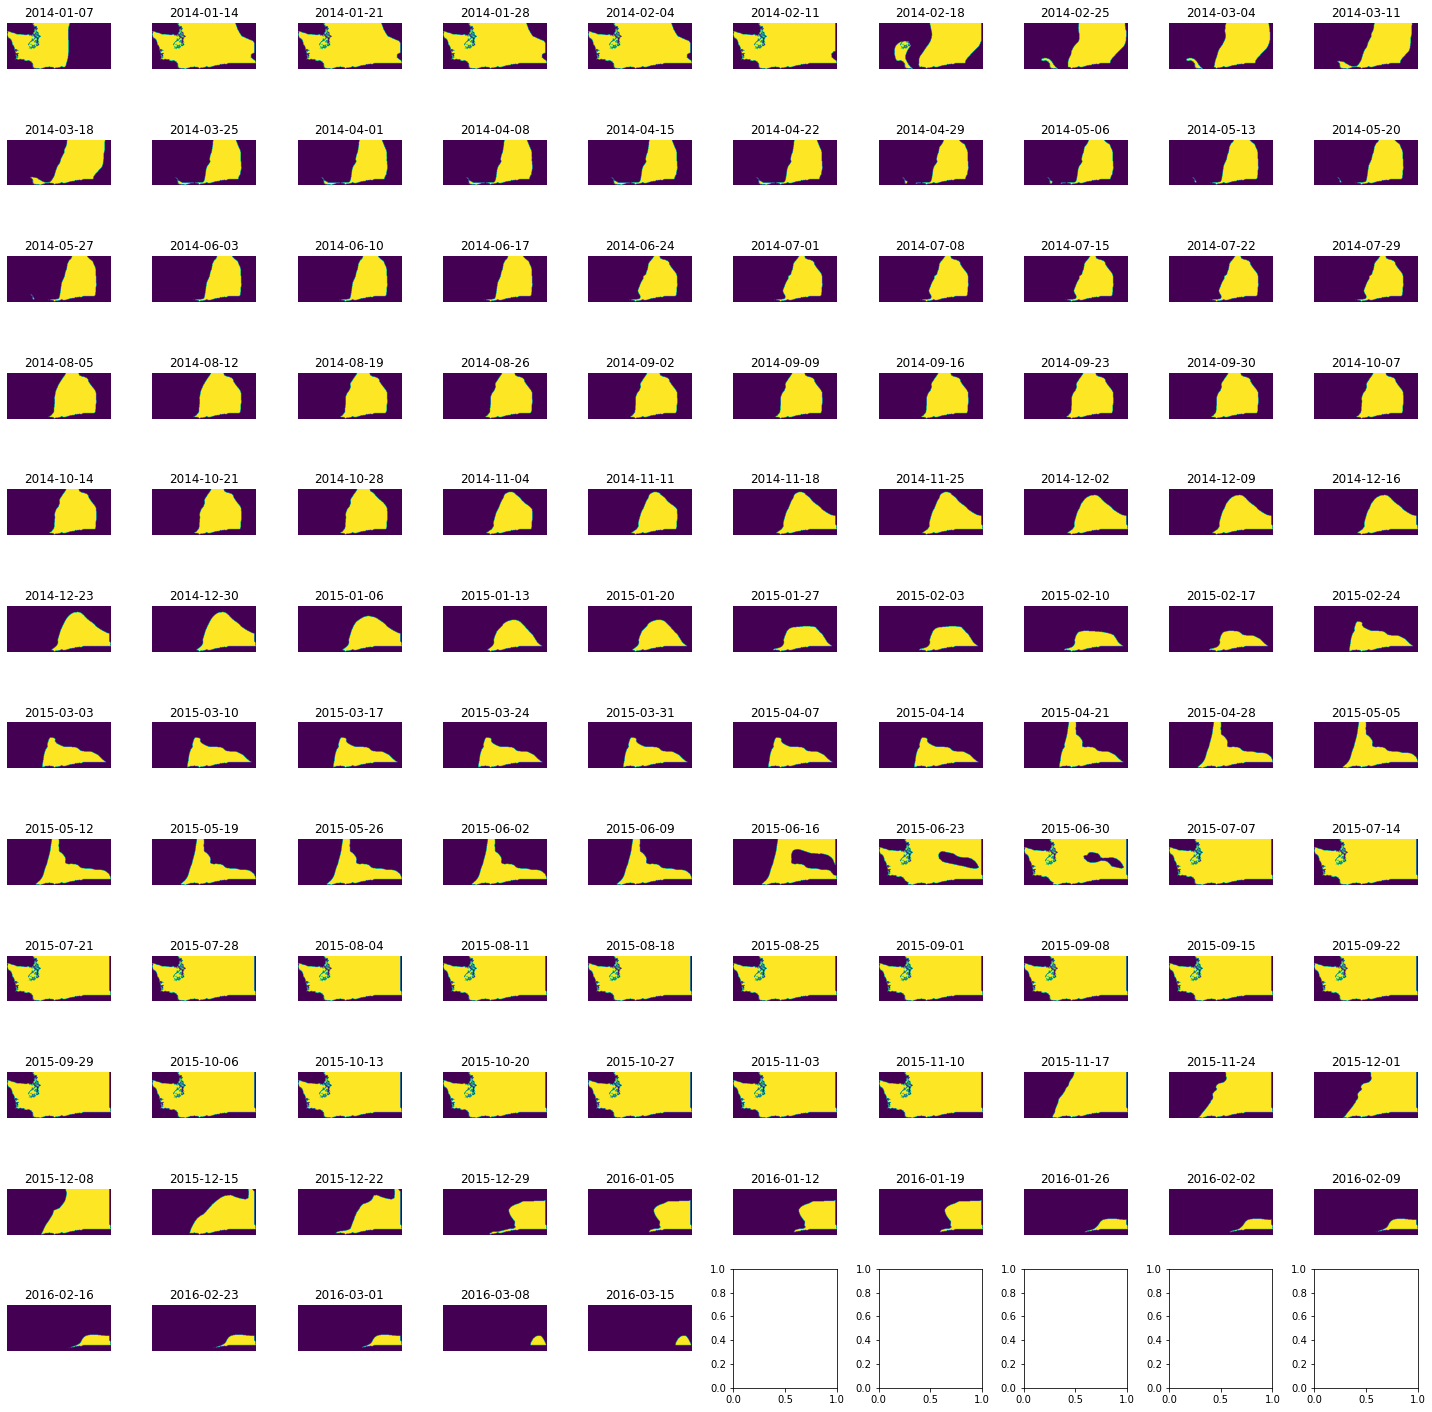

In [35]:
fig, axs = plt.subplots(12,10, figsize=(20,20))
axs_list = axs.ravel()

for i in np.arange(115):
    ax = axs_list[i]
    ax.imshow(usdm_thread_893[i,:,:])
    ax.axis('off')
    ax.set_aspect('equal')
    ax.set_title(np.datetime_as_string(usdm_original_period['date'].values[i])[:10])
plt.tight_layout()

In [36]:
# 1 --> True, which means yes, mask this value
# so I need to swap the 0 and 1's to get a mask
# that pulls out the values I want instead
# of hiding them
mask = np.ma.make_mask(usdm_thread_893==0)

In [37]:
masked_array = np.ma.masked_where(mask, usdm_original_period)

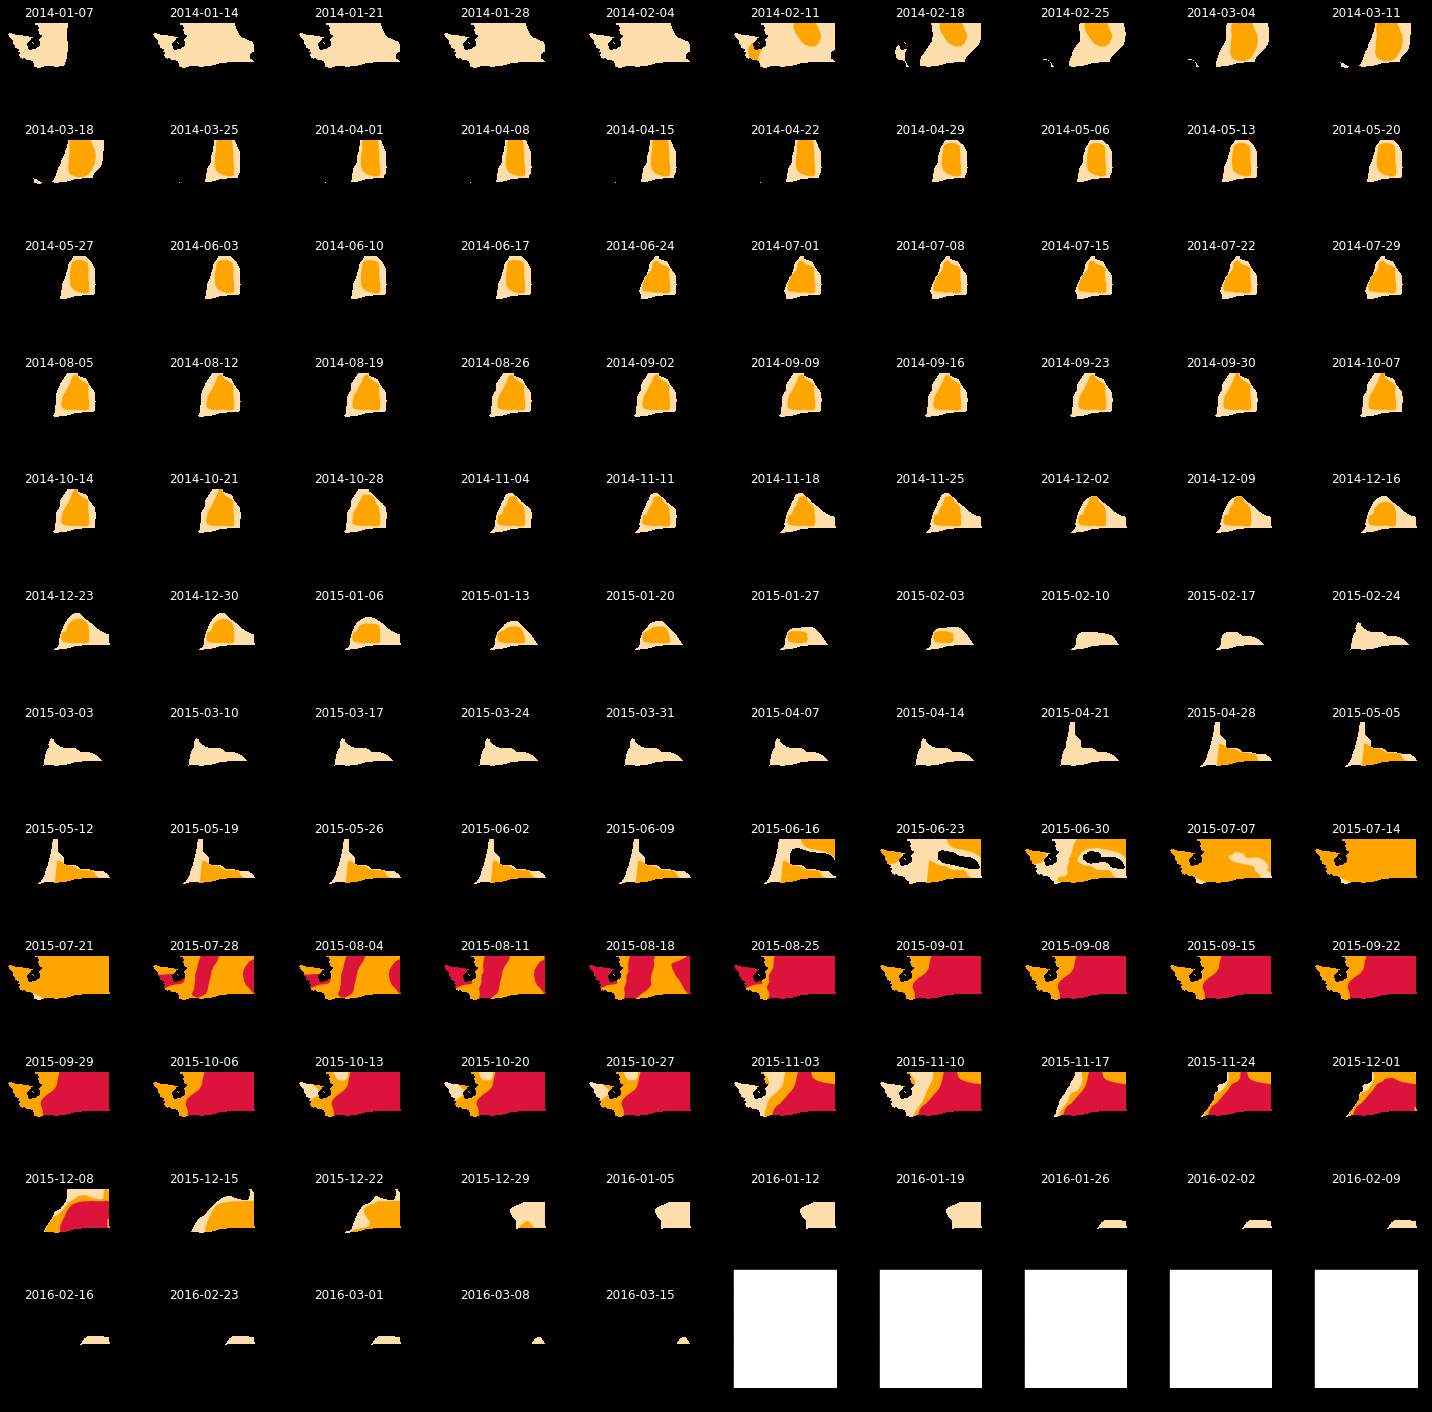

In [38]:
fig, axs = plt.subplots(12,10, figsize=(20,20))
axs_list = axs.ravel()

for i in np.arange(115):
    ax = axs_list[i]
    ax.imshow(masked_array[i,:,:], vmin=-1, vmax=4, cmap=cmap)
    ax.axis('off')
    ax.set_aspect('equal')
    ax.set_title(np.datetime_as_string(usdm_original_period['date'].values[i])[:10], color='w')
fig.set_facecolor(color='k')
plt.tight_layout()

Can I now animate this ...

In [39]:
import matplotlib.pyplot as plt
import matplotlib.animation
from matplotlib.animation import FuncAnimation
from IPython import display
from IPython.display import HTML


In [40]:
plt.rcParams["animation.html"] = "html5"

In [53]:
fig, ax = plt.subplots(figsize=(10,5))

#ax.axis('off')
#fig.set_facecolor('k')

def animate(i):
    ax.clear()
    ax.invert_yaxis()
    ax.set_facecolor('k')
    ax.set_aspect('equal')
    ax.set_title(np.datetime_as_string(usdm_original_period['date'].values[i])[:10])
    return (ax.pcolormesh(masked_array[i,:,:], cmap=cmap, vmin=-1, vmax=4),)

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=115, blit=True)
video = ani.to_jshtml()
html = display.HTML(video)
display.display(html)
plt.close()

In [54]:
writer = mpl.animation.ImageMagickWriter(fps=4)

In [56]:
path = '/pool0/home/steinadi/data/drought/drought_impact/animations/usdm_thread893_nb.gif'
try:
    os.remove(path)
except:
    pass
ani.save(path, writer=writer)